In [1]:
import itertools
import os

In [2]:
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
import lib

In [4]:
def corner(
    data,
    labels,
    colors,
    fields,
    field_labels,
    bins,
    quantiles,
    log_scale=False,
    figure_args=(),
    figure_kwargs={},
    gridspec_kwargs={},
):
    assert len(data) == len(labels) == len(colors)
    assert len(fields) == len(field_labels)
    for datum in data:
        for field in fields:
            assert field in datum.keys()

    # if figure_args is None:
    #     figure_args = ()
    # if figure_kwargs is None:
    #     figure_kwargs = {}
    # if gridspec_kwargs is None:
    #     gridpsec_kwargs = {}
    #     # gridspec_kwargs = {
    #     #     "left": 0,
    #     #     "right": 1,
    #     #     "bottom": 0,
    #     #     "top": 1,
    #     # }
    
    fig = plt.figure(*figure_args, **figure_kwargs)
    
    spec = fig.add_gridspec(ncols=len(fields), nrows=len(fields), **gridspec_kwargs)
    _params = spec.get_subplot_params(fig)

    axs = {}
    
    for i, (k, l) in enumerate(zip(fields, field_labels)):
        axs[i, i] = fig.add_subplot(spec[i, i])
        for datum, color in zip(data, colors):
            # axs[i, i].stairs(
            #     datum[k] / np.sum(datum[k]),
            #     bins[k],
            #     ec=color,
            # )
            lib.plotting.contour1d(
                axs[i, i],
                datum[k] / np.sum(datum[k]),
                bins[k],
                c=color,
            )
        if log_scale:
            axs[i, i].set_yscale("log")
        axs[i, i].set_box_aspect(1)
        axs[i, i].set_xlabel(l)
        axs[i, i].set_yticks([])
        # axs[i, i].set_yticklabels([])
        axs[i, i].label_outer()
    
    for i, (k1, l1) in enumerate(zip(fields, field_labels)):
        for j, (k2, l2) in enumerate(zip(fields, field_labels)):
            if i > j:
                axs[i, j] = fig.add_subplot(spec[i, j])
                axs[i, j].sharex(axs[j, j])
                lib.plotting.shareyx(axs[i, j], axs[i, i])
    
                for z, (datum, color) in enumerate(zip(data, colors)):
                    levels = lib.util.get_levels(datum[(k2, k1)], quantiles)
                    # if z == 0:
                    #     axs[i, j].pcolormesh(
                    #         bins[k2],
                    #         bins[k1],
                    #         datum[(k2, k1)].T,
                    #     )
                    lib.plotting.contour(
                        axs[i, j],
                        datum[(k2, k1)],
                        [bins[k2], bins[k1]],
                        levels=levels,
                        colors=[color for _ in levels],
                    )
                axs[i, j].set_box_aspect(1)
                axs[i, j].set_xlabel(l2)
                axs[i, j].set_ylabel(l1)
                axs[i, j].label_outer()
    
    fig.align_labels()
    fig.align_titles()
    
    label_artists = []
    for i, (label, color) in enumerate(zip(labels, colors)):
        _line = mpl.lines.Line2D([], [], color=color)
        label_artists.append(_line)
    
    fig.legend(label_artists, labels, loc="upper right", bbox_to_anchor=(_params.right, _params.top), frameon=False)
    
    
    return fig, axs

In [5]:
lib.plotting.setup()

In [6]:
shear_step_plus = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"
shear_step_minus = "g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

In [7]:
y6_shear = h5py.File(lib.const.Y6_SHEAR_CATALOG)
y6_neighbors = h5py.File(f"/pscratch/sd/s/smau/fiducial-neighbors/neighbors_y6.hdf5")
sim_shear_plus = h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_plus])
sim_shear_minus = h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_minus])
sim_neighbors_plus = h5py.File(f"/pscratch/sd/s/smau/fiducial-neighbors/neighbors_{shear_step_plus}.hdf5")
sim_neighbors_minus = h5py.File(f"/pscratch/sd/s/smau/fiducial-neighbors/neighbors_{shear_step_minus}.hdf5")

In [8]:
functions = {
    "g": lambda x: 30 - 2.5 * np.log10(x["pgauss_band_flux_g"][:]),
    "r": lambda x: 30 - 2.5 * np.log10(x["pgauss_band_flux_r"][:]),
    "i": lambda x: 30 - 2.5 * np.log10(x["pgauss_band_flux_i"][:]),
    "z": lambda x: 30 - 2.5 * np.log10(x["pgauss_band_flux_z"][:]),
    "g-r": lambda x: -2.5 * np.log10(x["pgauss_band_flux_g"][:] / x["pgauss_band_flux_r"][:]),
    "g-i": lambda x: -2.5 * np.log10(x["pgauss_band_flux_g"][:] / x["pgauss_band_flux_i"][:]),
    "r-i": lambda x: -2.5 * np.log10(x["pgauss_band_flux_r"][:] / x["pgauss_band_flux_i"][:]),
    "i-z": lambda x: -2.5 * np.log10(x["pgauss_band_flux_i"][:] / x["pgauss_band_flux_z"][:]),
    "log_snr": lambda x: np.log10(x["gauss_s2n"][:]),
    "log_size": lambda x: np.log10(1 + x["gauss_T_ratio"][:] * x["gauss_psf_T"][:]),
    "sep": lambda x: np.rad2deg(x["neighbor_distance"][:]) * 60 * 60

}

In [9]:
y6_args = {
    "g": y6_shear["mdet/noshear"],
    "r": y6_shear["mdet/noshear"],
    "i": y6_shear["mdet/noshear"],
    "z": y6_shear["mdet/noshear"],
    "g-r": y6_shear["mdet/noshear"],
    "g-i": y6_shear["mdet/noshear"],
    "r-i": y6_shear["mdet/noshear"],
    "i-z": y6_shear["mdet/noshear"],
    "log_snr": y6_shear["mdet/noshear"],
    "log_size": y6_shear["mdet/noshear"],
    "sep": y6_neighbors["mdet/noshear"],
}
sim_plus_args = {
    "g": sim_shear_plus["mdet/noshear"],
    "r": sim_shear_plus["mdet/noshear"],
    "i": sim_shear_plus["mdet/noshear"],
    "z": sim_shear_plus["mdet/noshear"],
    "g-r": sim_shear_plus["mdet/noshear"],
    "g-i": sim_shear_plus["mdet/noshear"],
    "r-i": sim_shear_plus["mdet/noshear"],
    "i-z": sim_shear_plus["mdet/noshear"],
    "log_snr": sim_shear_plus["mdet/noshear"],
    "log_size": sim_shear_plus["mdet/noshear"],
    "sep": sim_neighbors_plus["mdet/noshear"],
}
sim_minus_args = {
    "g": sim_shear_minus["mdet/noshear"],
    "r": sim_shear_minus["mdet/noshear"],
    "i": sim_shear_minus["mdet/noshear"],
    "z": sim_shear_minus["mdet/noshear"],
    "g-r": sim_shear_minus["mdet/noshear"],
    "g-i": sim_shear_minus["mdet/noshear"],
    "r-i": sim_shear_minus["mdet/noshear"],
    "i-z": sim_shear_minus["mdet/noshear"],
    "log_snr": sim_shear_minus["mdet/noshear"],
    "log_size": sim_shear_minus["mdet/noshear"],
    "sep": sim_neighbors_minus["mdet/noshear"],
}


In [10]:
NBINS = 100
bin_functions = {
    "g": np.linspace,
    "r": np.linspace,
    "i": np.linspace,
    "z": np.linspace,
    "g-r": np.linspace,
    "g-i": np.linspace,
    "r-i": np.linspace,
    "i-z": np.linspace,
    "log_snr": np.linspace,
    "log_size": np.linspace,
    "sep": np.geomspace,
}
bins = {
    k: bin_functions[k](
        np.nanmin(v(y6_args[k])),
        np.nanmax(v(y6_args[k])),
        NBINS + 1,
    )
    for k, v in functions.items()
}

In [11]:
columns = ["g", "r", "i", "z", "g-r", "g-i", "r-i", "i-z", "log_snr", "log_size", "sep"]
combinations = list(itertools.combinations(columns, 2))

In [12]:
histograms_y6 = {}

for k in columns:
    histograms_y6[k] = np.zeros(NBINS)

for (k1, k2) in combinations:
    histograms_y6[(k1, k2)] = np.zeros((NBINS, NBINS))

for k in columns:
    _histogram, _ = np.histogram(
        functions[k](y6_args[k]),
        bins=bins[k],
    )
    histograms_y6[k] += _histogram
    
for (k1, k2) in combinations:
    _histogram, _, _ = np.histogram2d(
        functions[k1](y6_args[k1]),
        functions[k2](y6_args[k2]),
        bins=[bins[k1], bins[k2]],
    )
    histograms_y6[(k1, k2)] += _histogram


In [13]:
histograms_plus = {}

for k in columns:
    histograms_plus[k] = np.zeros(NBINS)

for (k1, k2) in combinations:
    histograms_plus[(k1, k2)] = np.zeros((NBINS, NBINS))

for k in columns:
    _histogram, _ = np.histogram(
        functions[k](sim_plus_args[k]),
        bins=bins[k],
    )
    histograms_plus[k] += _histogram
    
for (k1, k2) in combinations:
    _histogram, _, _ = np.histogram2d(
        functions[k1](sim_plus_args[k1]),
        functions[k2](sim_plus_args[k2]),
        bins=[bins[k1], bins[k2]],
    )
    histograms_plus[(k1, k2)] += _histogram


In [14]:
histograms_minus = {}

for k in columns:
    histograms_minus[k] = np.zeros(NBINS)

for (k1, k2) in combinations:
    histograms_minus[(k1, k2)] = np.zeros((NBINS, NBINS))

for k in columns:
    _histogram, _ = np.histogram(
        functions[k](sim_minus_args[k]),
        bins=bins[k],
    )
    histograms_minus[k] += _histogram
    
for (k1, k2) in combinations:
    _histogram, _, _ = np.histogram2d(
        functions[k1](sim_minus_args[k1]),
        functions[k2](sim_minus_args[k2]),
        bins=[bins[k1], bins[k2]],
    )
    histograms_minus[(k1, k2)] += _histogram


In [15]:
histograms_sim = {}

for k in columns:
    histograms_sim[k] = 0.5 * (histograms_plus[k] + histograms_minus[k])

for (k1, k2) in combinations:
    histograms_sim[(k1, k2)] = 0.5 * (histograms_plus[(k1, k2)] + histograms_minus[(k1, k2)])


In [23]:
# histograms = [histograms_y6, histograms_plus, histograms_minus]
# colors = ["k", "r", "b"]
# labels = ["Y6", "sims (+)", "sims (-)"]

data = [histograms_y6, histograms_sim]
colors = [lib.plotting.mdet_color, lib.plotting.sims_color]
labels = ["Y6", "sims"]
quantiles = 1.0 - np.exp(-0.5 * np.array([1, 2, 3, 4, 5]) ** 2)
# quantiles = np.append(quantiles, 1)

In [24]:
print(quantiles)

[0.39346934 0.86466472 0.988891   0.99966454 0.99999627]


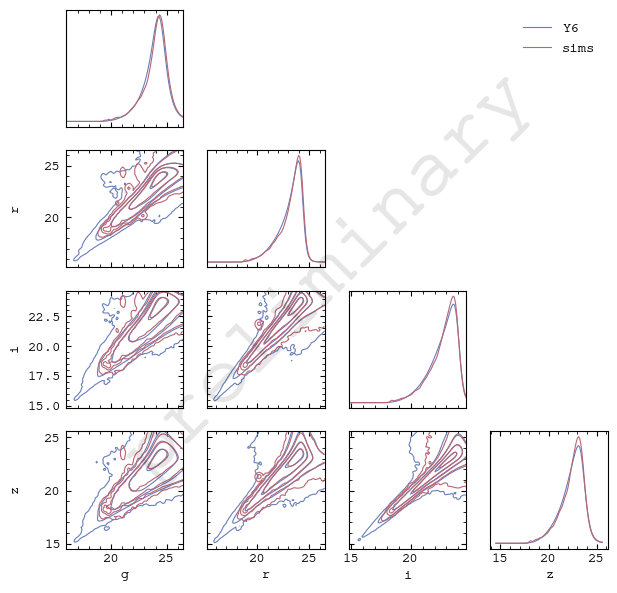

In [25]:
fields = ["g", "r", "i", "z"]
field_labels = ["$g$", "$r$", "$i$", "$z$"]

fig, _ = corner(
    data,
    labels=labels,
    colors=colors,
    fields=fields,
    field_labels=field_labels,
    bins=bins,
    quantiles=quantiles,
    # log_scale=True,
    figure_kwargs={"figsize": (7, 7)},
    # gridspec_kwargs={"left": 0, "right": 1, "bottom": 0, "top": 1},
)

lib.plotting.watermark(fig)

fig.savefig("corner_" + "_".join(fields) + ".pdf") 

plt.show(fig)

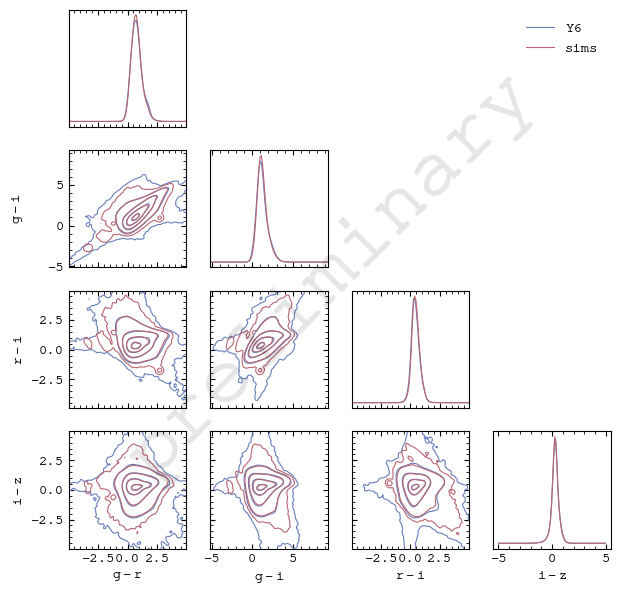

In [26]:
fields = ["g-r", "g-i", "r-i", "i-z"]
field_labels = ["$g-r$", "$g-i$", "$r-i$", "$i-z$"]

fig, axs = corner(
    data,
    labels=labels,
    colors=colors,
    fields=fields,
    field_labels=field_labels,
    bins=bins,
    quantiles=quantiles,
    # log_scale=True,
    figure_kwargs={"figsize": (7, 7)},
)

lib.plotting.watermark(fig)

fig.savefig("corner_" + "_".join(fields) + ".pdf") 

plt.show(fig)

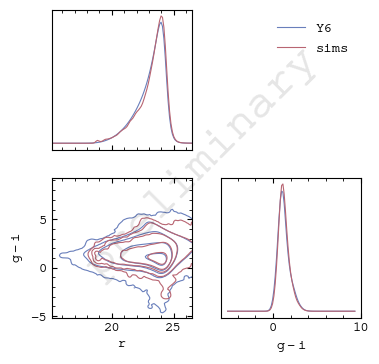

In [27]:
fields = ["r", "g-i"]
field_labels = ["$r$", "$g-i$"]

fig, axs = corner(
    data,
    labels=labels,
    colors=colors,
    fields=fields,
    field_labels=field_labels,
    bins=bins,
    quantiles=quantiles,
    # log_scale=True,
    figure_kwargs={"figsize": (4, 4)},
)

lib.plotting.watermark(fig)

fig.savefig("corner_" + "_".join(fields) + ".pdf") 

plt.show(fig)

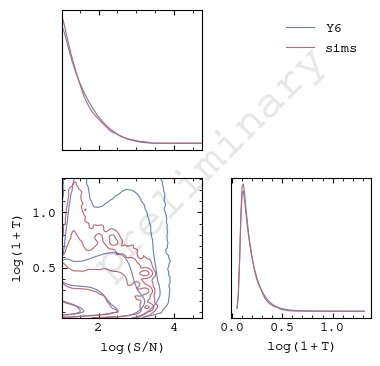

In [28]:
fields = ["log_snr", "log_size"]
field_labels = ["$log(S/N)$", "$log(1 + T)$"]

fig, axs = corner(
    data,
    labels=labels,
    colors=colors,
    fields=fields,
    field_labels=field_labels,
    bins=bins,
    quantiles=quantiles,
    # log_scale=True,
    figure_kwargs={"figsize": (4, 4)},
)

lib.plotting.watermark(fig)

fig.savefig("corner_" + "_".join(fields) + ".pdf") 

plt.show(fig)

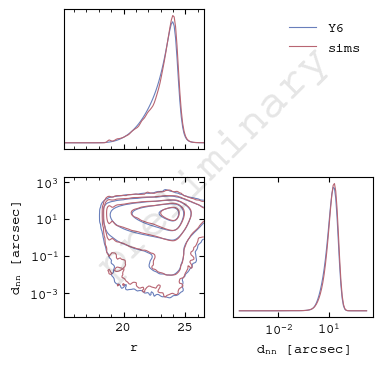

In [29]:
fields = ["r", "sep"]
field_labels = ["$r$", "$d_{nn}$ [arcsec]"]

fig, axs = corner(
    data,
    labels=labels,
    colors=colors,
    fields=fields,
    field_labels=field_labels,
    bins=bins,
    quantiles=quantiles,
    # log_scale=True,
    figure_kwargs={"figsize": (4, 4)},
)
axs[1, 1].set_xscale("log")
axs[1, 0].set_yscale("log")

lib.plotting.watermark(fig)

fig.savefig("corner_" + "_".join(fields) + ".pdf") 

plt.show(fig)